In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms.functional as TF
import os
import cv2
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving processed_data.zip to processed_data.zip


In [ ]:
import zipfile
import os

zip_path = "processed_data.zip"
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", os.listdir(extract_path))


Dataset extracted to: ['processed_data']


In [ ]:
def super_resolve(img):
    img_np = np.array(img)
    img_up = cv2.resize(img_np, (128, 128), interpolation=cv2.INTER_CUBIC)
    return TF.to_pil_image(img_up)


In [ ]:
img_size = 128
train_transform = transforms.Compose([
    transforms.Lambda(super_resolve),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Lambda(super_resolve),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])


In [ ]:
dataset = datasets.ImageFolder('/content/data/processed_data/train', transform=train_transform)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * (img_size // 8) * (img_size // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 30
patience = 5
fold = 1
best_model = None  # Track the overall best model across all folds
loss_history = []  # To store losses for all folds

for train_idx, val_idx in kf.split(dataset):
    print(f"--- Fold {fold}/5 ---")
    fold += 1
    train_data = Subset(dataset, train_idx)
    val_data = Subset(dataset, val_idx)

    train_data.dataset.transform = train_transform
    val_data.dataset.transform = test_transform

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=16)

    model = ImprovedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    best_loss = float('inf')  # Initialize best loss for this fold
    patience_counter = 0  # Initialize patience counter
    this_fold_loss = {'train': [], 'val': []}  # Store losses for this fold

    best_fold_model = None  # To store best model for the current fold

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        this_fold_loss['train'].append(avg_train_loss)
        this_fold_loss['val'].append(avg_val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.3f} - Val Loss: {avg_val_loss:.3f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss  # Update the best loss
            patience_counter = 0
            best_fold_model = model.state_dict()  # Save the best model for this fold
            print(f"Best model for this fold saved at Epoch {epoch+1}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    loss_history.append(this_fold_loss)

    # Save the best model for this fold to disk
    torch.save(best_fold_model, f'best_model_fold_{fold-1}.pth')
    print(f"Best model for fold {fold-1} saved!")

    # Evaluate the model on the validation set of the current fold
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


--- Fold 1/5 ---
Epoch 1 - Train Loss: 4.441 - Val Loss: 1.763
Best model for this fold saved at Epoch 1
Epoch 2 - Train Loss: 1.430 - Val Loss: 1.107
Best model for this fold saved at Epoch 2
Epoch 3 - Train Loss: 1.007 - Val Loss: 1.069
Best model for this fold saved at Epoch 3
Epoch 4 - Train Loss: 1.021 - Val Loss: 0.968
Best model for this fold saved at Epoch 4
Epoch 5 - Train Loss: 0.995 - Val Loss: 1.134
Epoch 6 - Train Loss: 1.000 - Val Loss: 0.959
Best model for this fold saved at Epoch 6
Epoch 7 - Train Loss: 0.915 - Val Loss: 0.925
Best model for this fold saved at Epoch 7
Epoch 8 - Train Loss: 0.844 - Val Loss: 1.021
Epoch 9 - Train Loss: 0.886 - Val Loss: 0.920
Best model for this fold saved at Epoch 9
Epoch 10 - Train Loss: 0.802 - Val Loss: 0.843
Best model for this fold saved at Epoch 10
Epoch 11 - Train Loss: 0.831 - Val Loss: 3.600
Epoch 12 - Train Loss: 0.890 - Val Loss: 0.946
Epoch 13 - Train Loss: 0.717 - Val Loss: 0.902
Epoch 14 - Train Loss: 0.734 - Val Loss: 0.8

In [ ]:
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load('best_model_fold_5.pth'))
model.eval()


ImprovedCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2

In [ ]:
# Load test dataset
test_dataset = datasets.ImageFolder(root='/content/data/processed_data/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("Final Test Set Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Final Test Set Classification Report:
              precision    recall  f1-score   support

         dry       0.73      0.67      0.70        12
      normal       0.67      0.91      0.77        11
        oily       0.78      0.58      0.67        12

    accuracy                           0.71        35
   macro avg       0.72      0.72      0.71        35
weighted avg       0.73      0.71      0.71        35



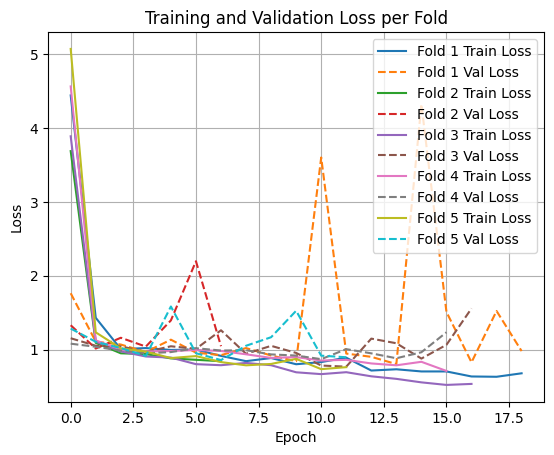

In [ ]:
# Plot training and validation loss per fold
for i, fold_loss in enumerate(loss_history):
    plt.plot(fold_loss['train'], label=f'Fold {i+1} Train Loss')
    plt.plot(fold_loss['val'], label=f'Fold {i+1} Val Loss', linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Fold")
plt.legend()
plt.grid(True)
plt.show()


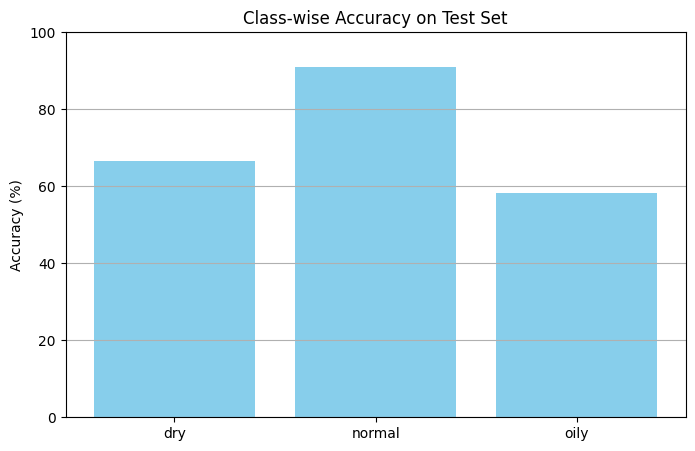

In [ ]:
from sklearn.metrics import accuracy_score

import numpy as np
class_correct = [0] * len(test_dataset.classes)
class_total = [0] * len(test_dataset.classes)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

accuracy_per_class = [100 * correct / total if total > 0 else 0
                      for correct, total in zip(class_correct, class_total)]

plt.figure(figsize=(8, 5))
plt.bar(test_dataset.classes, accuracy_per_class, color='skyblue')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy on Test Set')
plt.ylim([0, 100])
plt.grid(axis='y')
plt.show()


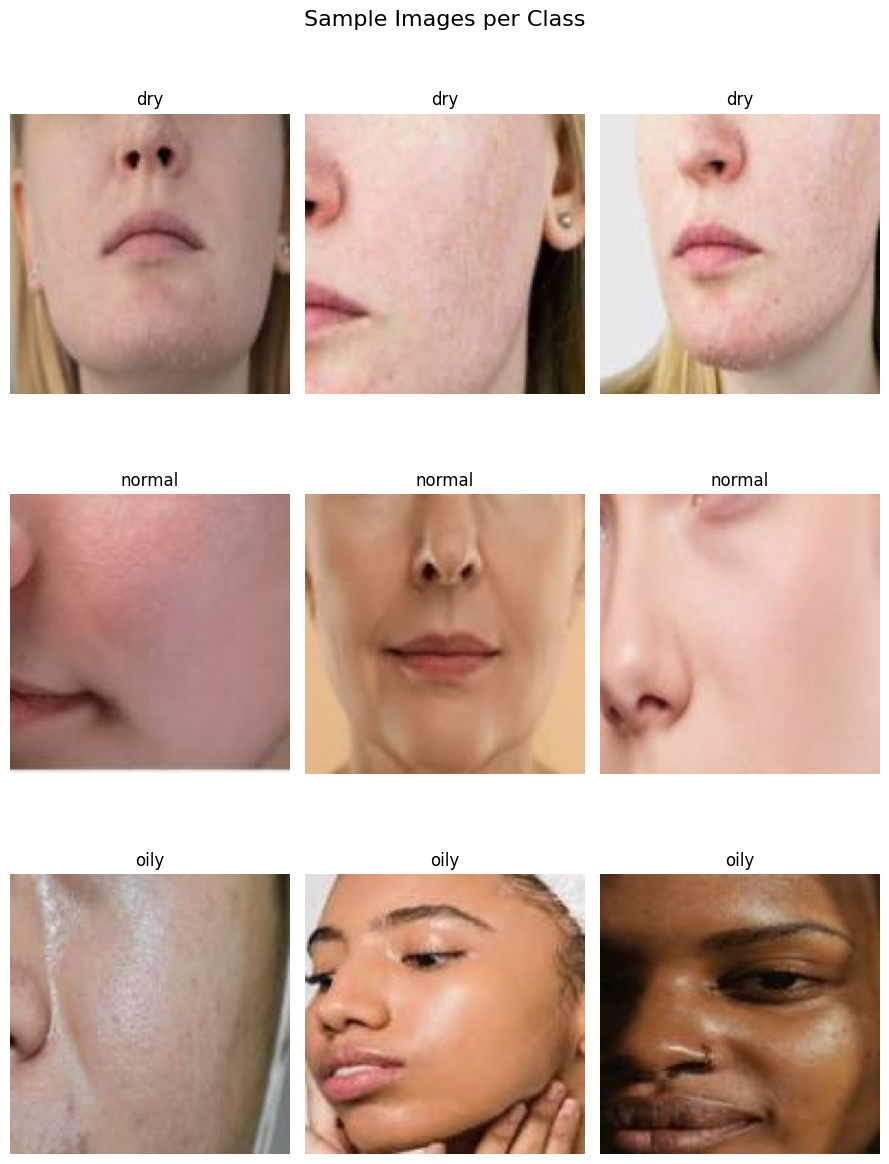

In [ ]:

fig, axes = plt.subplots(len(test_dataset.classes), 3, figsize=(9, 12))

for class_idx in range(len(test_dataset.classes)):
    class_name = test_dataset.classes[class_idx]
    count = 0
    for img, label in test_dataset:
        if label == class_idx:
            ax = axes[class_idx][count]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.set_title(f"{class_name}")
            ax.axis('off')
            count += 1
        if count == 3:
            break

plt.tight_layout()
plt.suptitle("Sample Images per Class", y=1.02, fontsize=16)
plt.show()


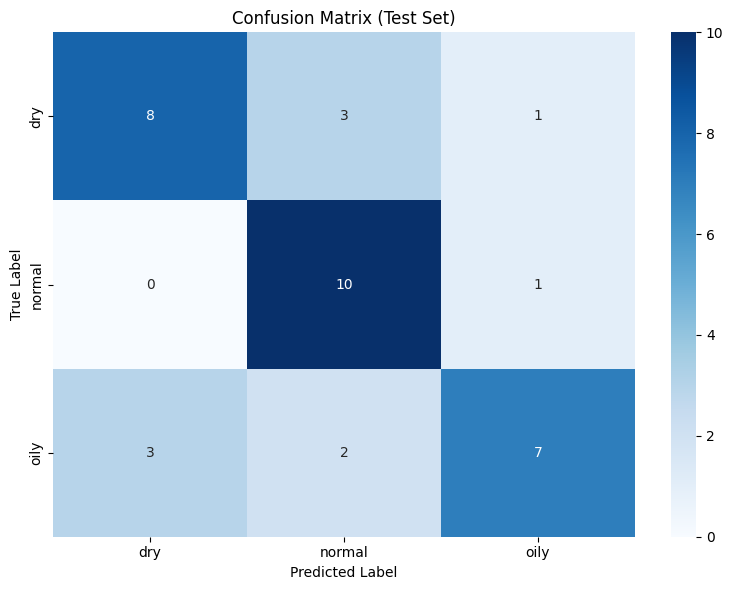

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()
